In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [ ]:

%cd /gdrive/MyDrive/ANNDL/Challange_2

/gdrive/MyDrive/ANNDL/Challange_2


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
seed = 42

np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11689525370831840674
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1590802479921288557
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.15.0


In [ ]:
categories = np.load('/gdrive/MyDrive/categories.npy')
categories

valid_periods = np.load('/gdrive/MyDrive/valid_periods.npy')
valid_periods.shape
valid_periods

timeseries_data = np.load('/gdrive/MyDrive/training_data.npy')
timeseries_data

array([[0.        , 0.        , 0.        , ..., 0.60277778, 0.36759259,
        0.33148148],
       [0.        , 0.        , 0.        , ..., 0.6       , 0.46      ,
        0.396     ],
       [0.        , 0.        , 0.        , ..., 0.96048126, 0.94650625,
        0.97714021],
       ...,
       [0.        , 0.        , 0.        , ..., 0.52631579, 0.58223684,
        0.55263158],
       [0.        , 0.        , 0.        , ..., 0.44559585, 0.58549223,
        0.40414508],
       [0.        , 0.        , 0.        , ..., 0.54268293, 0.6097561 ,
        0.59146341]])

In [ ]:

timeseries_data_df = pd.DataFrame(timeseries_data)
timeseries_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float64(2776)
memory usage: 1016.6 MB


In [ ]:
min, max = (9999, -1), (0, -1)
for i, tuple in enumerate(valid_periods):
    diff = tuple[1] - tuple[0]
    if diff < min[0]: min = (diff, i)
    if diff > max[0]: max = (diff, i)

min, max
index_shortest = min[1]
index_longest = max[1]

In [ ]:

sample_first = timeseries_data_df.T[0]
sample_shortest = timeseries_data_df.T[min[1]]
sample_longest = timeseries_data_df.T[max[1]]


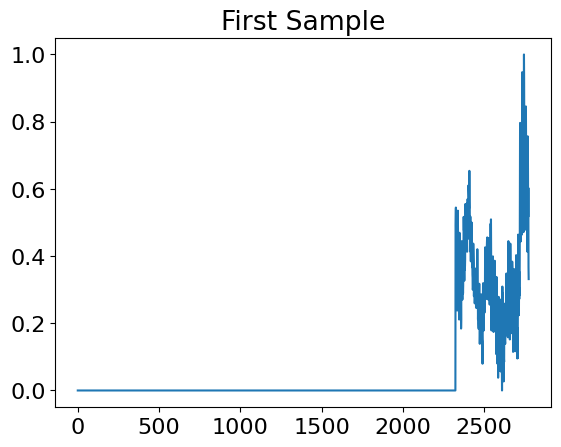

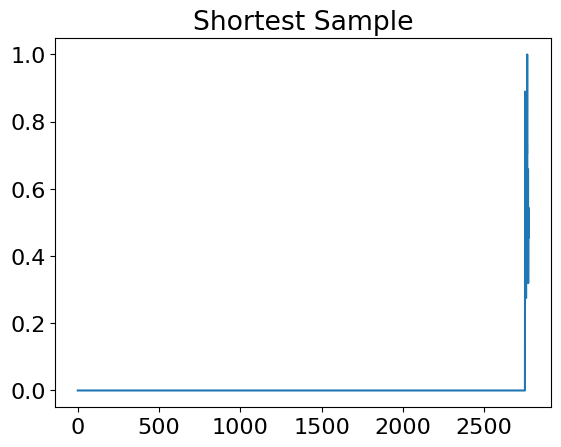

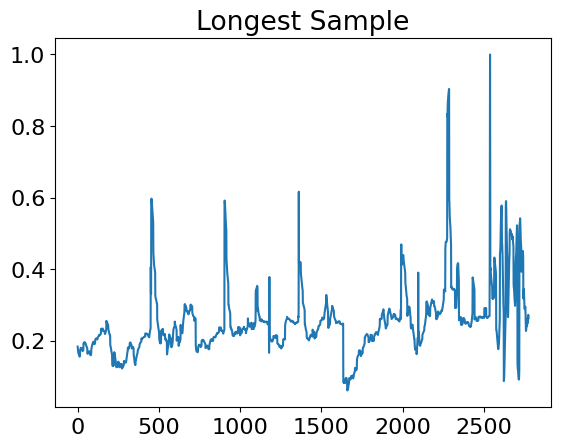

In [ ]:

import matplotlib.pyplot as plt

plt.plot(sample_first)
plt.title('First Sample')
plt.show()

plt.plot(sample_shortest)
plt.title('Shortest Sample')
plt.show()

plt.plot(sample_longest)
plt.title('Longest Sample')
plt.show()

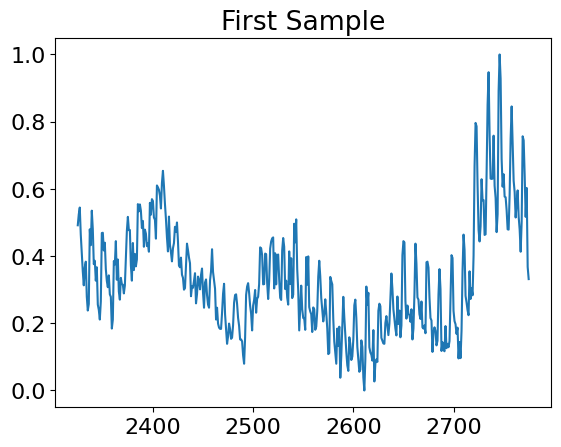

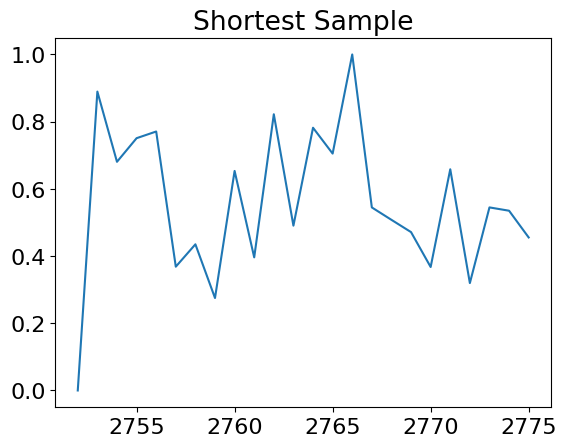

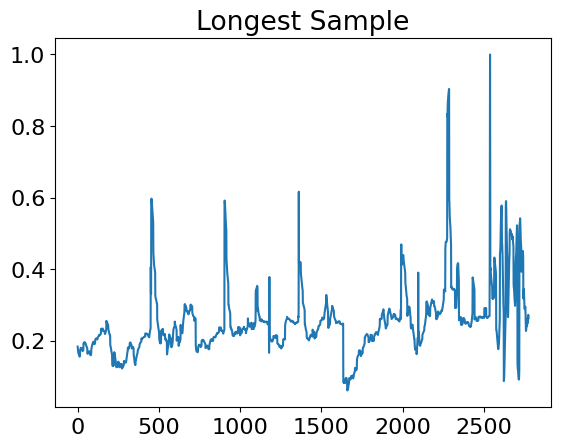

In [ ]:
start_first, end_first = valid_periods[0]
sample_first_trimmed = sample_first[start_first:end_first]

plt.plot(sample_first_trimmed)
plt.title('First Sample')
plt.show()



start_shortest, end_shortest = valid_periods[index_shortest]
sample_shortest_trimmed = sample_shortest[start_shortest:end_shortest]

plt.plot(sample_shortest_trimmed)
plt.title('Shortest Sample')
plt.show()



start_longest, end_longest = valid_periods[index_longest]
sample_longest_trimmed = sample_longest[start_longest:end_longest]

plt.plot(sample_longest_trimmed)
plt.title('Longest Sample')
plt.show()

In [ ]:
category_counts = np.unique(categories, return_counts=True)
for category, count in zip(category_counts[0], category_counts[1]):
    print(f"Category {category}: {count}")


Category A: 5728
Category B: 10987
Category C: 10017
Category D: 10016
Category E: 10975
Category F: 277


In [ ]:

# Function to create sub-arrays of size 218 from valid periods with sliding
def create_sub_arrays(data, valid_periods, onehot_categories, window_size=218, slide=10):
    sub_arrays = []
    cat_values = []
    for i in range(len(data)):
        start, end = valid_periods[i]
        valid_data = data[i, start:end]
        length = len(valid_data)

        if length < window_size:
            # Padding with mean
            #mean_value = np.mean(valid_data)
            padding = np.full((window_size - length,), 0)
            padded_data = np.concatenate([valid_data, padding])
            sub_arrays.append(padded_data)
            cat_values.append(onehot_categories[i])
        else:
            for j in range(start, end - window_size + 1, slide):
                sub_arrays.append(data[i, j:j + window_size])
                cat_values.append(onehot_categories[i])

    return np.array(sub_arrays), np.array(cat_values)


from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
reshaped_categories = categories.reshape(-1, 1)
onehot_categories = encoder.fit_transform(reshaped_categories)

onehot_categories


array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [ ]:

sub_arrays, cat_data = create_sub_arrays(timeseries_data, valid_periods, onehot_categories)


In [ ]:


X = sub_arrays[:, :200]  # First 200 values as features
y = sub_arrays[:, 200:]  # Next 18 values as targets


from sklearn.model_selection import train_test_split
# Train-test split
X_train, X_test, y_train, y_test, cat_train, cat_test = train_test_split(X, y, cat_data, test_size=0.2, random_state=42)


# Reshaping input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

,D,E,A,C,B,F
0-300,7712,10320,4276,8527,10145,230
301-600,2094,571,1368,1235,722,40
601-900,115,30,71,143,67,6
901-1200,5,5,1,17,3,1
1201-1500,2,3,0,3,3,0
1501-1800,0,0,0,2,0,0
1801-2100,3,0,1,0,0,0
2101-2400,0,1,0,1,0,0
2401-2776,1,0,0,2,0,0


In [ ]:
window = 100
telescope = 9
stride = 20

In [ ]:

input_shape = (window, 1)
category_shape = (6, )
output_shape = (telescope, 1)
batch_size = 16
epochs = 50

In [ ]:
import tensorflow.keras.layers as tfkl
import tensorflow as tf

def build_RESNET_LSTM_model(input_shape, category_shape, output_shape):

    # Time series input
    time_series_input = tfkl.Input(shape=input_shape, name='time_series_input')
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True), name='bidirectional_lstm')(time_series_input)
    x = tfkl.Dropout(0.2)(x)
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = tfkl.Dropout(0.2)(x)

    category_input = tfkl.Input(shape=category_shape, name='category_input')
    category_processed = tfkl.Dense(20, activation='relu')(category_input)
    category_processed = tfkl.RepeatVector(input_shape[0])(category_processed)

    combined = tfkl.Concatenate()([x, category_processed])


    # ResNet blocks
    rn_output = tfkl.Conv1D(128, 1, padding='same')(combined)
    rn_output = tfkl.BatchNormalization()(rn_output)
    rn_output = tfkl.Activation('relu')(rn_output)

    rn_output = tfkl.Conv1D(128, 3, padding='same')(rn_output)
    rn_output = tfkl.BatchNormalization()(rn_output)
    rn_output = tfkl.Activation('relu')(rn_output)

    rn_output = tfkl.Conv1D(128, 1, padding='same')(rn_output)
    rn_output = tfkl.BatchNormalization()(rn_output)


    combined = tfkl.Conv1D(128, 1, padding='same')(combined)
    combined = tfkl.BatchNormalization()(combined)


    resnet_combined = tfkl.Add()([combined, rn_output])
    resnet_combined = tfkl.Activation('relu')(resnet_combined)

    #conv layers
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu')(resnet_combined)
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same')(x)

    # Crop output if necessary
    crop_size = output_layer.shape[1] - output_shape[0]
    if crop_size > 0:
        output_layer = tfkl.Cropping1D((0, crop_size))(output_layer)

    model = tf.keras.Model(inputs=[time_series_input, category_input], outputs=output_layer, name='RESNET_CONV_LSTM_with_Categories')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model


In [ ]:
model = build_RESNET_LSTM_model((200, 1),(6,), (18, 1))

In [ ]:

X_train.shape

(204264, 200, 1)

In [ ]:
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    patience=10,
    factor=0.1,
    min_lr=1e-5
)

history = model.fit(
    x = [X_train, cat_train],
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = ([X_test, cat_test], y_test),
    callbacks = [
        early_stopping,
        reduce_lr
    ]
).history

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()



In [ ]:

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()
preds = model.predict([X_val, X_val_category])
preds.shape